# Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/kaggle/kaggle_practice/항공사진_선인장_식별'

/content/drive/MyDrive/kaggle/kaggle_practice/항공사진_선인장_식별


# EDA

## 데이터 탐색

In [4]:
import pandas as pd 

data_path = 'dataset/'
labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [5]:
# from zipfile import ZipFile

# with ZipFile(data_path + 'train.zip') as zipper : 
#   zipper.extractall()
# with ZipFile(data_path + 'test.zip') as zipper : 
#   zipper.extractall()  

In [6]:
labels.head(5)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
submission.head(5)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


## Data Visualization

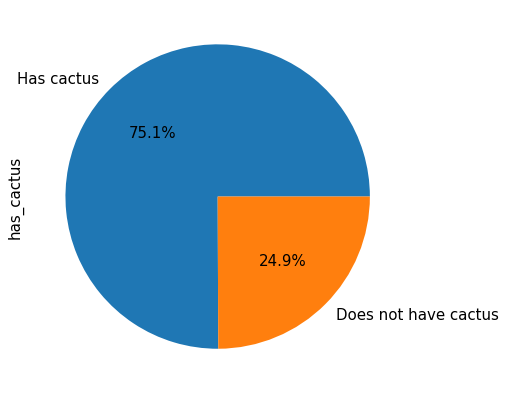

In [8]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline 

mpl.rc('font', size = 15)
plt.figure(figsize = (7, 7))
label =  ['Has cactus', 'Does not have cactus']
labels['has_cactus'].value_counts().plot.pie(labels = label, autopct = '%.1f%%')

In [9]:
import os 

num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

print(f'# of train : {num_train}')
print(f'# of test : {num_test}')

# of train : 17500
# of test : 4000


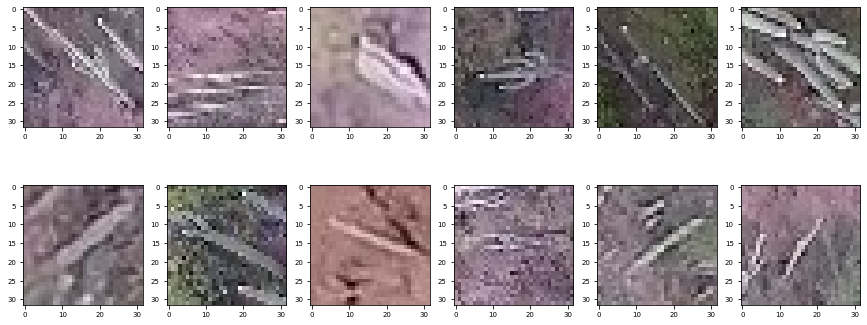

In [10]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus'] == 1]['id'][-12:]
last_has_cactus_img_name

for idx, img_name in enumerate(last_has_cactus_img_name) : 
  img_path = 'train/' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

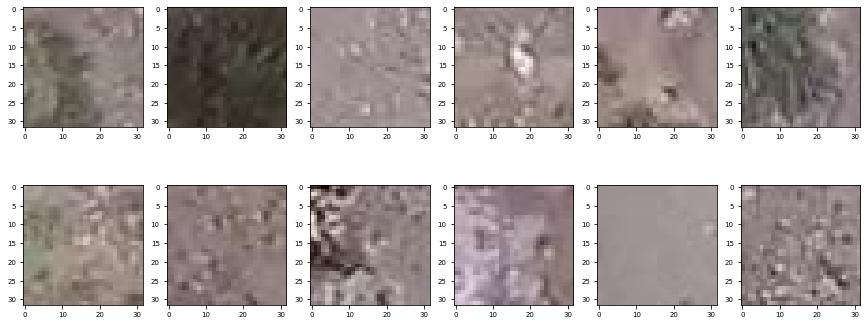

In [11]:
mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_not_has_cactus_img_name = labels[labels['has_cactus'] == 0]['id'][-12:]
last_not_has_cactus_img_name

for idx, img_name in enumerate(last_not_has_cactus_img_name) : 
  img_path = 'train/' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

In [12]:
image.shape # 가로 32 x 세로 32 x 3채널 (R, G, B)

(32, 32, 3)

# 베이스라인 모델
파이토치를 활용해서 모델을 생성 (CNN)
- 시드값 고정 및 GPU 장비 설정
  - 시드값 고정은 결과 재현을 위한 작업
- 데이터 준비
  - 1. 훈련/검증 데이터 분리
  - 2. 데이터셋 클래스 정의
  - 3. 데이터셋 생성
  - 4. 데이터 로더 생성
- 모델 생성 (CNN)
  - 신경망 모델 클래스를 직접 설계한 후 인스턴스 생성
- 모델 훈련
  - 1. Loss function과 optimizer 설정
  - 2. 모델 훈련
- 성능 검증
- 예측 및 제출

## 시드값 고정 및 GPU 장비 설정

### 시드값 고정

파이토치로 딥러닝 모델링을 할 때는 모델 훈련시에 시드값을 설정하는 것이 아니라 처음에 고정한다.

In [13]:
import torch 
import random 
import numpy as np 
import os 

seed = 50 
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed) # 파이썬 난수 생성기 시드 고정 
np.random.seed(seed) # 넘파이 난수 생성기 시드 고정 
torch.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (CPU)
torch.cuda.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (GPU)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티 GPU 사용 시) 
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False # 벤치마크 기능 해제
torch.backends.cudnn.enables = False # cudnn 사용 해제

### GPU 장비 설정

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

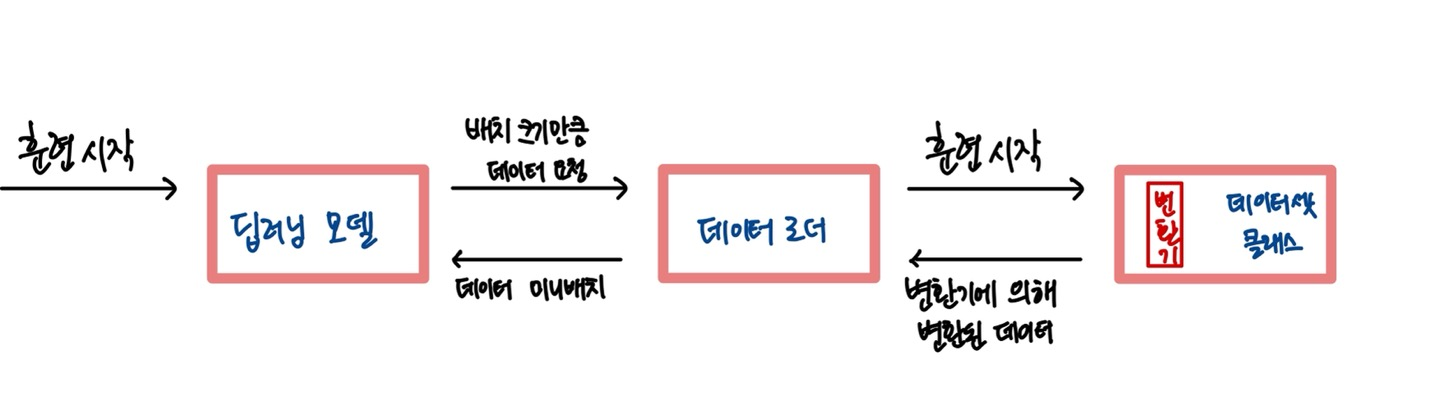

## 데이터 준비

### 훈련 데이터, 검증 데이터 분리
labels에는 주최 측에서 제공한 train.csv 파일의 내용이 담겨있다. `train_test_split()` 함수를 이용해 이 데이터를 훈련 데이터와 검증 데이터로 나눈다.

In [15]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [16]:
from sklearn.model_selection import train_test_split 

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels,
                                test_size = .1, 
                                stratify = labels['has_cactus'],
                                random_state = 50)

print(f'# of train data : {len(train)}')
print(f'# of valid data : {len(valid)}')

# of train data : 15750
# of valid data : 1750


### 데이터셋 클래스 준비

In [17]:
import cv2 
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

파이토치의 Dataset 클래스를 활용해서 데이터셋 객체를 만들 수 있다.

 Dataset 클래스는 추상 클래스이며, Dataset 클래스를 상속받은 다음 특수 메서드인 `__len__()`과 `__getitem__()` 을 오버라이딩 해야한다.
- `__len()__` : 데이터셋 크기를 반환
- `__getitem()__`: 인덱스를 전달받아 인덱스에 해당하는 데이터 반환

> 추상 클래스는 곧바로 객체를 생성할 수 없고 상속만 할 수 있는 클래스이다. 이를 사용하는 이유는 상속받는 클래스들의 메서드를 규격하하기 위해서이다. (상속을 강제해 메서드 시그니처를 일치시키기 위함)

In [18]:
class ImageDataset(Dataset) : 
  # 초기화 메서드 (생성자)
  def __init__(self, df, img_dir = './', transform = None) : 
    super().__init__() # 상속받은 Dataset의 생성자 호출
    
    # 전달받은 인수들 저장
    self.df = df
    self.img_dir = img_dir
    self.transform = transform

  # 데이터셋 크기 반환 메서드
  def __len__(self) :
    return len(self.df)

  # 인덱스에 해당하는 데이터 반환 메서드
  def __getitem__(self, idx) : 
    img_id = self.df.iloc[idx, 0]
    img_path = self.img_dir + img_id
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.df.iloc[idx, 1]

    if self.transform is not None : 
      image = self.transform(image)
    return image, label

### 데이터셋 생성
파이토치 모델로 이미지를 다루기 위해서는 이미지 데이터를 텐서 타입으로 바꿔야 한다. 

In [19]:
from torchvision import transforms # 이미지 변환을 위한 모듈 

transform = transforms.ToTensor()

`ToTensor()` 메서드로 이미지를 텐서로 바꾼다. 이 때 (가로 픽셀 수, 세로 픽셀 수, 채널 수) 형상이 (채널 수, 가로 픽셀 수, 세로 픽셀 수)로 바뀐다. 
- 즉 32x32x3 -> 3x32x32

보통 여러 가지 변환을 적용하기 위해서 변환기 몇 개를 결합해서 사용한다. 성능 개선을 진행할 때 여러 변환기를 결합해보고, 지금은 간단하게 텐서로 변환하는 변환기만 생성한다.

훈련 데이터셋과 검증 데이터셋 생성
- ImageDataset() 클래스 사용

In [20]:
dataset_train = ImageDataset(df = train, img_dir = 'train/', transform = transform)
dataset_valid = ImageDataset(df = valid, img_dir = 'train/', transform = transform)

### 데이터 로더 생성
데이터셋 다음으로 데이터 로더가 생성되어야 한다. 데이터 로더는 지정한 배치 크기만큼 데이터를 불러오는 객체이다. 딥러닝 모델을 훈련할 때는 배치 단위로 데이터를 가져와 훈련한다. 

`torch.utils.data`의 `DataLoader` 클래스로 데이터 로더를 만들 수 있다. 

In [21]:
from torch.utils.data import DataLoader

loader_train = DataLoader(dataset = dataset_train, batch_size = 32, shuffle = True)
loader_valid = DataLoader(dataset = dataset_valid, batch_size = 32, shuffle = False)

일반적으로 배치 크기는 4 \~ 256까지 다양하게 설정한다. (2의 배수를 사용)

배치 크기가 작아지면 규제 효과가 있어 일반화 성능이 좋아지지만 한 번에 불러들이는 데이터가 적어서 반복 수가 많아지고 훈련 시간도 길어진다. 그리고 배치 크기가 작을수록 학습률도 낮게 설정해야 하는데 이것 또한 학습 시간을 지연시키는 원인이 된다.

## 모델 생성

기본적인 CNN 모델 생성 

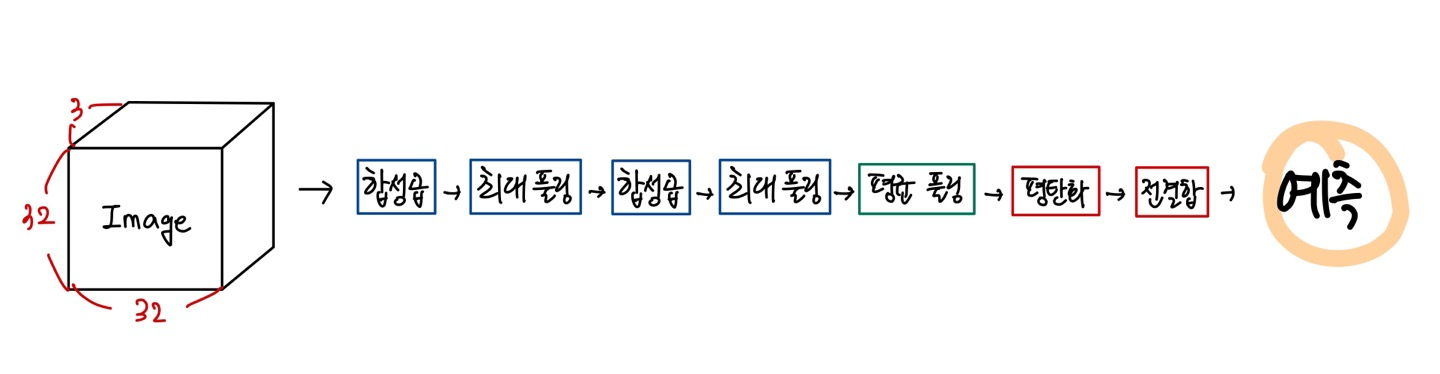

In [22]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수들을 모아둔 모듈

CNN 모델은 nn.Module을 상속해 정의한다. 

그리고 순전파 후 결과를 반환하는 메서드인 `forward()`를 재정의한다. 파이토치에서 `nn.Module`은 모든 신경망 모듈의 기반 클래스이다.

In [23]:
class Model(nn.Module) :
  # 신경망 계층 정의
  def __init__(self) :
    super().__init__() # 상속받은 nn.Module의  __init__() 메서드 호출

    # 첫 번째 합성곱 계층
    self.conv1 = nn.Conv2d(in_channels = 3, 
                           out_channels = 32,
                           kernel_size = 3,
                           padding = 2)
    
    # 두 번째 합성곱 계층
    self.conv2 = nn.Conv2d(in_channels = 32, 
                           out_channels = 64,
                           kernel_size = 3,
                           padding = 2)
    
    # 최대 풀링 계층
    self.max_pool = nn.MaxPool2d(kernel_size = 2)

    # 평균 풀링 계층
    self.avg_pool = nn.AvgPool2d(kernel_size = 2)

    # 전결합 계층
    self.fc = nn.Linear(in_features = 64 * 4 * 4, out_features = 2)

  # 순전파 출력 정의
  def forward(self, x) : 
    x = self.max_pool(F.relu(self.conv1(x)))
    x = self.max_pool(F.relu(self.conv2(x)))
    x = self.avg_pool(x)
    x = x.view(-1, 64 * 4 * 4) # 평탄화
    x = self.fc(x)
    return x

입력값이 64x4x4인 이유

$$
N_{out} = \lfloor \frac{N_{in} + 2P - K}{S}\rfloor + 1
$$

- $N_{out}$ : 출력 데이터 크기
- $N_{in}$ : 입력 데이터 크기
- $P$ : 패딩 크기
- $K$ : 필터(커널 크기)
- $S$ : 스트라이드 크기

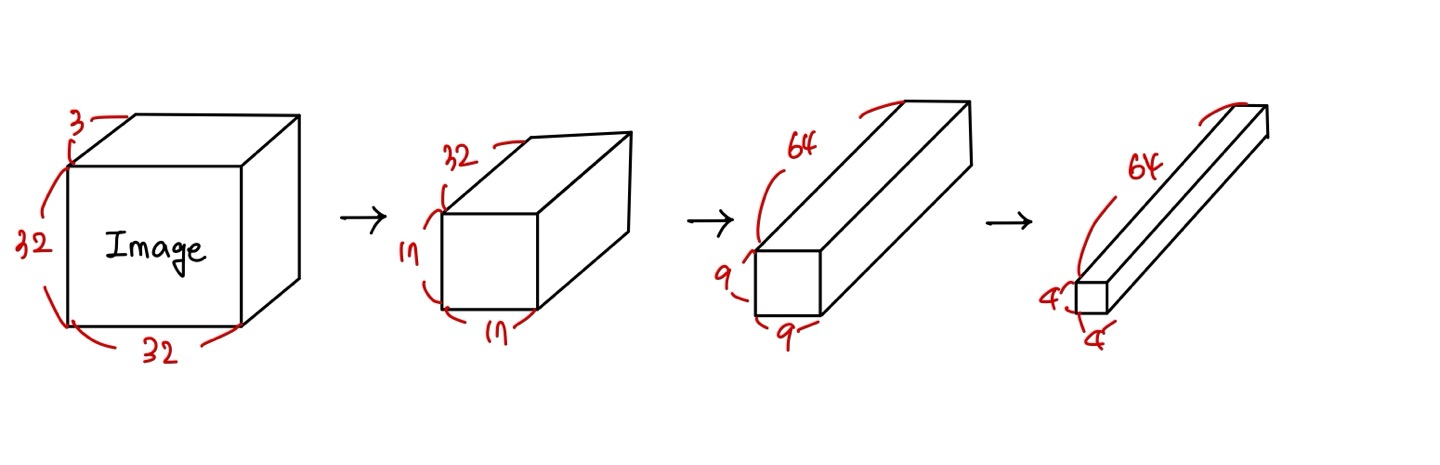

데이터 형상 (개별 이미지)
0. 초기 이미지 
- (3 $\times$ 32 $\times$ 32)

1. 첫 번째 합성곱 연산
- $
\lfloor \frac{32 + 2 \cdot 2 - 3}{1}\rfloor + 1 = 34
$

2. 첫 번째 최대 풀링
- $
\lfloor \frac{34}{2}\rfloor = 17
$

3. 두 번째 합성곱 연산
- $
\lfloor \frac{17 + 2 \cdot 2 - 3}{1}\rfloor + 1 = 19
$

4. 두 번째 최대 풀링
- $
\lfloor \frac{19}{2}\rfloor = 9
$

5. 평균 풀링
- $
\lfloor \frac{9}{2}\rfloor = 4
$

6. 평탄화
- 64 $\times$ 4 $\times$ 4 = 1024 

미니배치를 고려할 경우 미니배치 수를 곱해준 값이 최종 데이터 형상이 된다. 

예를 들면, 미니배치를 고려하지 않는 경우 첫 번째 합성곱 연산에서 (32, 34, 34), 첫 번째 최대 풀링에서 (32, 17, 17)이 되지만,

 미니배치를 고려하는 경우 첫 번째 합성곱 연산에서 ($\textbf{32}$, 32, 34, 34), 첫 번째 최대 풀링에서 ($\textbf{32}$, 32, 17, 17)이 된다.

In [24]:
# CNN 모델 생성하여 device 장비에 할당
model = Model().to(device)

In [25]:
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

## 모델 훈련

모델을 훈련시키기 전에 손실 함수와 옵티마이저를 정의해야 한다.

### 손실 함수 설정
신경망 모델 훈련은 가중치를 갱신하는 작업인데, 가중치 갱신은 예측값과 실제값의 손실이 작아지는 방향으로 이루어진다. 여기서는 크로스 엔트로피를 손실 함수로 사용한다. 

In [26]:
# loss function 
criterion = nn.CrossEntropyLoss()

### 옵티마이저 설정 
옵티마이저는 최적 가중치를 찾아주는 알고리즘이다. 기본 옵티마이저인 SGD로 설정한다. 

In [27]:
# optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr = .01)

### 모델 훈련
이미지용 딥러닝 모델을 훈련하는 과정
1. 데이터 로더에서 배치 크기만큼 데이터 불러오기
2. 불러온 이미지 데이터와 레이블 데이터를 장비에 할당
3. 옵티마이저 내 기울기를 초기화
4. 신경망 모델에 입력 데이터를 전달해 순전파하여 출력값 계산
5. 예측값과 실제 레이블을 비교해서 손실 계산
6. 손실을 기반으로 역전파 수행
7. 역전파로 구한 기울기를 통해 가중치 갱신
8. 1~7을 iteration 수만큼 반복
9. 1~8을 epoch 수만큼 반복

한 에폭은 훈련 데이터 전체에 대해 훈련을 수행했음을 의미한다. 미니배치를 수행하기 때문에 여러 번의 반복을 수행해야 한 에폭이 진행된다. 

충분한 훈련을 위해 수십~수백 에폭만큼 훈련을 한다. 너무 적으면 과소적합, 너무 많으면 과대적합이 발생한다.

훈련 데이터는 15,750개이고 배치 크기가 32이기 때문에 한 에폭을 위한 반복 횟수는 15,750 / 32 를 올림한 493번이다. 

In [28]:
import math 

math.ceil(len(train) / 32)

493

데이터 로더는 하나의 배치를 한 묶음으로 처리하기 때문에 데이터 로더의 길이를 구해도 반복 횟수를 구할 수 있다.

In [29]:
len(loader_train)

493

**모델 훈련**
- 10 epochs
- 하나의 에폭이 끝날 때마다 손실값을 출력하도록 한다.

In [ ]:
# 총 에폭
epochs = 10

# 총 에폭만큼 수행
for epoch in range(epochs) : 
  epoch_loss = 0 # 에폭별 손실값 초기화

  # # 에폭 내 반복 횟수만큼 반복
  # for images, labels in loader_train : 
  #   # 이미지, 레이블 데이터 미니배치를 장비에 할당
  #   images = images.to(device)
  #   labels = labels.to(device)

  # 에폭 내 반복 횟수만큼 반복
  for i, data in enumerate(loader_train) : 
    # 이미지, 레이블 데이터 미니배치를 장비에 할당
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)


    # 옵티마이저 내 기울기 초기화
    optimizer.zero_grad()
    
    # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
    outputs = model(images)

    # 손실 함수를 활용해 outputs와 labels의 손실값 계산
    loss = criterion(outputs, labels)

    # 현재 배치에서의 손실 추가
    epoch_loss += loss.item()

    # 역전파 수행 
    loss.backward() 

    # 가중치 갱신
    optimizer.step()

    if i % 10 == 0 : 
      print(f'iter {i} / epoch {epoch + 1} ')

  # 훈련 데이터 손실값 출력
  print(f' epoch [{epoch + 1} / {epochs}] - loss : {epoch_loss / len(loader_train):.4f}')

iter 0 / epoch 1 
iter 10 / epoch 1 
iter 20 / epoch 1 


## 성능 검증

In [ ]:
from sklearn.metrics import roc_auc_score

true_list = [] 
preds_list = [] 

In [ ]:
# 모델을 평가 상태로 설정
model.eval()

with torch.no_grad() : # 기울기 계산 비활성화
  for images, labels in loader_valid :
    images = images.to(device)
    labels = labels.to(device)

    # 순전파 
    outputs = model(images)
    preds = torch.softmax(outputs.cpu(), dim = 1)[:, 1]
    true = lables.cpu()

    preds_list.extend(preds)
    true_list.extend(true)

print(f'valid set ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')
